In [2]:
import essentia
import numpy as np
import matplotlib.pyplot as plt
from essentia.standard import MonoLoader, TensorflowPredictMusiCNN, TensorflowPredict2D


2025-08-19 18:04:13.258348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-08-19 18:04:13.258435: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[   INFO   ] MusicExtractorSVM: no classifier models were configured by default
2025-08-19 18:04:14.456021: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-19 18:04:14.459805: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-08-19 18:04:1

In [3]:
AUDIO = 'audio/MEMD_audio/2052.mp3'

audio = MonoLoader(filename=AUDIO, sampleRate=16000, resampleQuality=4)()
embedding_model = TensorflowPredictMusiCNN(graphFilename="models/msd-musicnn-1.pb", output="model/dense/BiasAdd")
embeddings = embedding_model(audio)

model = TensorflowPredict2D(graphFilename="models/deam-msd-musicnn-2.pb", output="model/Identity")

# predictions.shape
# windowLength = 3 sec, hopLength = 1.5 seconds
predictions = model(embeddings)


2025-08-19 18:04:15.480702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-19 18:04:15.480763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4060 Laptop GPU computeCapability: 8.9
coreClock: 2.01GHz coreCount: 24 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 238.45GiB/s
2025-08-19 18:04:15.480774: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1766] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-08-19 18:04:15.480784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:125

In [4]:
def normalize(values):
    # arousal and valences are ranged from [1,9]
    # normalize to [-1,1]
    return 2 * ((values - 1) / 8) - 1

In [5]:
predictions = normalize(predictions)
predictions


array([[-0.09579158, -0.17273474],
       [-0.00324178, -0.12769401],
       [ 0.07082021, -0.02802861],
       [-0.03723335,  0.00463736],
       [-0.17736983, -0.2778088 ],
       [ 0.08171821, -0.16368175],
       [-0.03753793,  0.01985967],
       [-0.11529207,  0.02456033],
       [-0.04210269, -0.06909585],
       [-0.00468135, -0.0456537 ],
       [-0.05757797, -0.02941644],
       [-0.10374188, -0.01484239],
       [-0.04038799, -0.03538668],
       [-0.21326125, -0.01982892],
       [-0.23557436,  0.01448679],
       [-0.2964157 , -0.0136627 ],
       [-0.253879  ,  0.15499783],
       [-0.14013267,  0.10462654],
       [-0.24572098, -0.10092282],
       [-0.2690286 ,  0.01918435],
       [-0.16897261,  0.07618666],
       [-0.1480093 , -0.05216622],
       [-0.28811628, -0.01943886],
       [-0.24921715,  0.00454092],
       [-0.09567487,  0.03801405],
       [-0.10651052,  0.07915759],
       [-0.24603522, -0.01251221],
       [-0.28677958, -0.0726155 ],
       [-0.30363482,

In [6]:
def plotVA(predictions, duration=45.0):
    valence = predictions[:, 0]
    arousal = predictions[:, 1]

    n = len(predictions)
    hop = duration / n
    time = np.arange(n) * hop + hop / 2.0

    plt.figure(figsize=(9,4))
    plt.plot(time, valence, label="Valence")
    plt.plot(time, arousal, label="Arousal")
    plt.xlabel('Time(s)')
    plt.ylabel('score')
    plt.title('V/A over time')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return 

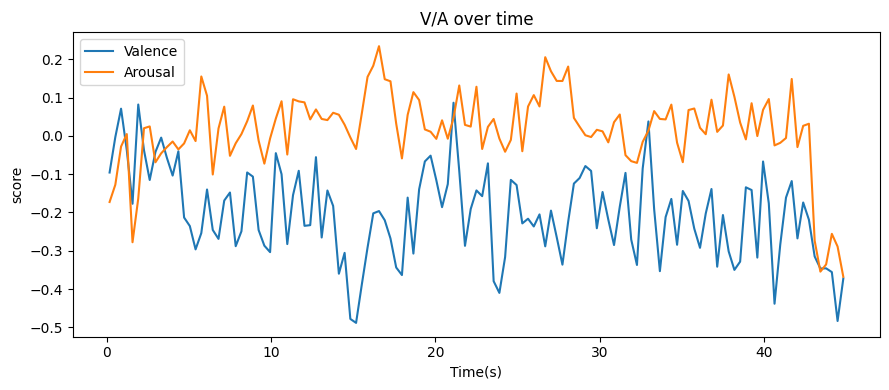

In [7]:
plotVA(predictions=predictions)

In [8]:
from matplotlib.animation import FuncAnimation, PillowWriter

def animateVA(predictions):
    valence = predictions[:, 0]
    arousal = predictions[:, 1]
    n = len(predictions)

    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlabel("Valence", loc='right', labelpad=15)
    ax.set_ylabel("Arousal", loc='top', labelpad=15)
    ax.set_title("VA on 2D plane")

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    dot, = ax.plot([],[], marker='o', markersize=8, linestyle="")

    def init():
        dot.set_data([],[])
        return dot,

    def update(frame):
        # X means the animation is ending
        if frame >= n-5:
            dot.set_marker('X')
        dot.set_data([valence[frame]], [arousal[frame]])
        return dot,
    
    animation = FuncAnimation(fig, update, frames=n, init_func=init, blit=True)
    animation.save('VA_on_2d_plane.gif', writer=PillowWriter(fps=8))
    plt.show()
    plt.close()



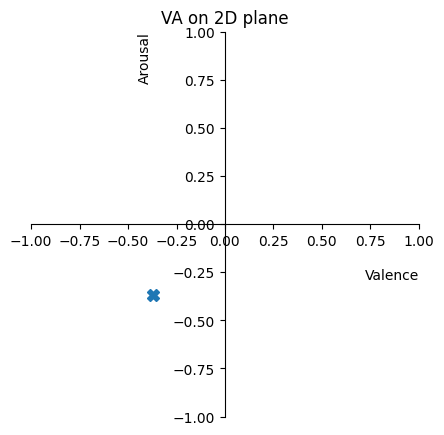

In [9]:
animateVA(predictions=predictions)

In [10]:
def polarCoordinate(predictions):
    valence = predictions[:, 0]
    arousal = predictions[:, 1]

    res = []
    r = np.sqrt(valence**2 + arousal**2)
    theta = np.arctan2(valence, arousal) * 180 / np.pi
    theta = np.where(theta < 0, theta + 360, theta)

    return zip(r, theta)

In [11]:
coordinates = np.array(list(polarCoordinate(predictions=predictions)))


In [12]:
def hard_classify(theta):
    if 0 <= theta < 22.5:
        return "happy"
    elif 22.5 <= theta < 45:
        return "elated"
    elif 45 <= theta < 67.5:
        return "excited"
    elif 67.5 <= theta < 90:
        return "alert"
    elif 90 <= theta < 112.5:
        return "tense"
    elif 112.5 <= theta < 135:
        return "nervous"
    elif 135 <= theta < 157.5:
        return "stressed"
    elif 157.5 <= theta < 180:
        return "upset"
    elif 180 <= theta < 202.5:
        return "sad"
    elif 202.5 <= theta < 225:
        return "depressed"
    elif 225 <= theta < 247.5:
        return "lethargic"
    elif 247.5 <= theta < 270:
        return "fatigued"
    elif 270 <= theta < 292.5:
        return "calm"
    elif 292.5 <= theta < 315:
        return "relaxed"
    elif 315 <= theta < 337.5:
        return "serene"
    else:
        return "contented"

hardClassifyMatrix = np.vectorize(hard_classify)

In [13]:
emotionCennters = {
    "happy": [0.9, 0.1],
    "surprise": [0.3, 0.9],
    "sad": [-0.8, -0.5],
    "angry": [-0.1, 0.8],
    "fear": [-0.3, 0.8],
    "disgust": [-0.4, 0.6],
}

def soft_classify(point, sigma=0.3):
    #Uses Radial Basis Function Kernel

    weights = {}

    for emotion, center in emotionCennters.items():
        dist = np.linalg.norm(point - center)
        weights[emotion] = np.exp(-dist**2 / (2 * sigma**2))

    #normalize
    total = sum(weights.values())
    for k in weights:
        weights[k] /= total
        
    return weights



In [14]:
labels = hardClassifyMatrix(coordinates[:, 1])
labels

array(['depressed', 'sad', 'tense', 'calm', 'depressed', 'stressed',
       'relaxed', 'calm', 'depressed', 'sad', 'lethargic', 'fatigued',
       'lethargic', 'fatigued', 'calm', 'fatigued', 'relaxed', 'relaxed',
       'fatigued', 'calm', 'relaxed', 'fatigued', 'fatigued', 'calm',
       'calm', 'relaxed', 'fatigued', 'fatigued', 'fatigued', 'relaxed',
       'relaxed', 'fatigued', 'relaxed', 'relaxed', 'calm', 'calm',
       'serene', 'calm', 'calm', 'calm', 'calm', 'calm', 'fatigued',
       'fatigued', 'calm', 'relaxed', 'relaxed', 'serene', 'relaxed',
       'relaxed', 'calm', 'fatigued', 'calm', 'calm', 'relaxed', 'calm',
       'calm', 'fatigued', 'calm', 'fatigued', 'excited', 'serene',
       'calm', 'calm', 'relaxed', 'fatigued', 'calm', 'calm', 'fatigued',
       'fatigued', 'fatigued', 'relaxed', 'fatigued', 'calm', 'relaxed',
       'calm', 'relaxed', 'relaxed', 'relaxed', 'relaxed', 'relaxed',
       'calm', 'calm', 'calm', 'fatigued', 'calm', 'calm', 'fatigued',
       

In [15]:
slabels = [soft_classify(point) for point in predictions]
slabels

[{'happy': np.float64(0.03856092625546691),
  'surprise': np.float64(0.010084359710938785),
  'sad': np.float64(0.5048755668079272),
  'angry': np.float64(0.07500407182000775),
  'fear': np.float64(0.05949951329104597),
  'disgust': np.float64(0.31197556211461347)},
 {'happy': np.float64(0.13787086465879825),
  'surprise': np.float64(0.029032822942022442),
  'sad': np.float64(0.23274782543994887),
  'angry': np.float64(0.13612941827697111),
  'fear': np.float64(0.08791456965767112),
  'disgust': np.float64(0.3763044990245881)},
 {'happy': np.float64(0.21681625534059534),
  'surprise': np.float64(0.06758106735540446),
  'sad': np.float64(0.04649308614085935),
  'angry': np.float64(0.2040985900551404),
  'fear': np.float64(0.11180770404792571),
  'disgust': np.float64(0.35320329706007464)},
 {'happy': np.float64(0.05174310773717588),
  'surprise': np.float64(0.044313533586047164),
  'sad': np.float64(0.06870234103090568),
  'angry': np.float64(0.20861865380399017),
  'fear': np.float64(0

In [ ]:
import madmom

GitHub username: nicaless 
Github email: nfronda@gmail.com